In [1]:
file_path = "Phishing_Email.csv"

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib') 
pd.options.mode.chained_assignment = None

In [3]:
dataset = pd.read_csv(file_path)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
dataset.shape

(18650, 3)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [7]:
dataset.head(2)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to "" sons "" being "" treated like senior relatives "" . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not completely impossible ) . alexis mr",Safe Email
1,1,"the other side of * galicismos * * galicismo * is a spanish term which names the improper introduction of french words which are spanish sounding and thus very deceptive to the ear . * galicismo * is often considered to be a * barbarismo * . what would be the term which designates the opposite phenomenon , that is unlawful words of spanish origin which may have crept into french ? can someone provide examples ? thank you joseph m kozono < kozonoj @ gunet . georgetown . edu >",Safe Email


In [8]:
dataset.tail(2)

,Unnamed: 0,Email Text,Email Type
18648,18649,"press clippings - letter on californian utilities please find attached the following article : ' californian utilities ' - financial times ( also sent to california distribution team ) kind regards , kuldeep chana",Safe Email
18649,18650,empty,Phishing Email


In [9]:
dataset.sample(2) 

Unnamed: 0  \
15406       15407   
11250       11251   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [10]:
dataset.dtypes

Unnamed: 0     int64
Email Text    object
Email Type    object
dtype: object

In [11]:
unique_values = dataset.nunique()
print("Unique values in each column:")
print(unique_values)

Unique values in each column:
Unnamed: 0    18650
Email Text    17537
Email Type        2
dtype: int64


In [12]:
dataset['Email Type'].value_counts()

Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64

In [13]:
dataset.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [ ]:
dataset = dataset.dropna()

In [15]:
dataset.shape

(18634, 3)

In [16]:
dataset['Email Type'] = dataset['Email Type'].replace({
    'Safe Email': 0,
    'Phishing Email': 1
})


In [17]:
dataset.to_csv("Phishing_Email_Processed.csv", index=False)

In [18]:
N = 500

data_r = dataset.groupby('Email Type').sample(n=N, random_state=786)

data_r['Email Type'].value_counts()

Email Type
0    500
1    500
Name: count, dtype: int64

In [19]:
data_r.to_csv("Phishing_Email_Reduced.csv", index=False)

In [20]:
data = data_r.sample(frac=0.95, random_state=786)
data_indices = data.index
data = data.reset_index(drop=True)

In [21]:
data_unseen = data_r.drop(data_indices)
data_unseen = data_unseen.reset_index(drop=True)

In [22]:
from pycaret.classification import *

In [23]:
exp = setup(
    data=data,
    target='Email Type',                
    text_features=['Email Text'], 
    session_id=42,
)

,Description,Value
0,Session id,42
1,Target,Email Type
2,Target type,Binary
3,Original data shape,"(950, 3)"
4,Transformed data shape,"(950, 20727)"
5,Transformed train set shape,"(665, 20727)"
6,Transformed test set shape,"(285, 20727)"
7,Numeric features,1
8,Text features,1
9,Preprocess,True


In [24]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.9519,0.9868,0.9577,0.9484,0.9523,0.9037,0.9052,0.9340
lr,Logistic Regression,0.9444,0.9799,0.9337,0.9555,0.9439,0.8887,0.8900,6.1320
lda,Linear Discriminant Analysis,0.9370,0.9755,0.9668,0.9146,0.9392,0.8740,0.8771,5.4860
rf,Random Forest Classifier,0.9309,0.9636,0.9518,0.9165,0.9326,0.8619,0.8648,1.1510
et,Extra Trees Classifier,0.9309,0.9678,0.9459,0.9205,0.9322,0.8618,0.8638,1.5210
catboost,CatBoost Classifier,0.9309,0.9774,0.9577,0.9104,0.9324,0.8618,0.8652,78.8290
lightgbm,Light Gradient Boosting Machine,0.8993,0.9626,0.9008,0.8996,0.8994,0.7986,0.7999,1.3260
gbc,Gradient Boosting Classifier,0.8949,0.9634,0.9004,0.8926,0.8947,0.7898,0.7930,6.2370
ada,Ada Boost Classifier,0.8903,0.9407,0.9005,0.8827,0.8909,0.7805,0.7820,3.4940
xgboost,Extreme Gradient Boosting,0.8888,0.9567,0.9006,0.8820,0.8901,0.7775,0.7799,8.5580


In [25]:
print(best_model)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=42, solver='auto',
                tol=0.0001)


In [28]:
import os
os.makedirs("./pkl", exist_ok=True)
save_model(best_model, './pkl/phishing_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['Unnamed: 0'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(ad...
                                     transformer=EmbedTextFeatures(kwargs=None,
                                                                   method='tf-idf'))),
            

In [29]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9701,0.9804,0.9706,0.9706,0.9706,0.9403,0.9403
1,0.9403,0.9581,1.0000,0.8947,0.9444,0.8804,0.8867
2,0.9851,0.9982,0.9697,1.0000,0.9846,0.9701,0.9706
3,0.9254,0.9902,0.9091,0.9375,0.9231,0.8506,0.8510
4,0.9403,0.9973,0.9091,0.9677,0.9375,0.8805,0.8820
5,0.9697,0.9798,0.9697,0.9697,0.9697,0.9394,0.9394
6,0.9242,0.9862,0.9697,0.8889,0.9275,0.8485,0.8520
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9545,0.9982,0.9697,0.9412,0.9552,0.9091,0.9095


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [30]:
print(tuned_model)

RidgeClassifier(alpha=0.61, class_weight=None, copy_X=True, fit_intercept=False,
                max_iter=None, positive=False, random_state=42, solver='auto',
                tol=0.0001)


In [31]:
save_model(tuned_model, './pkl/phishing_model_tuned')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['Unnamed: 0'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(ad...
                                     transformer=EmbedTextFeatures(kwargs=None,
                                                                   method='tf-idf'))),
            

## Plots

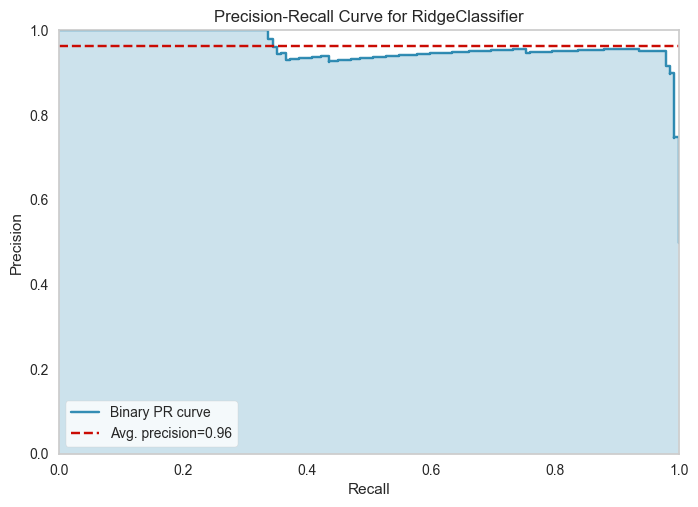

In [34]:
plot_model(tuned_model, plot = 'pr')

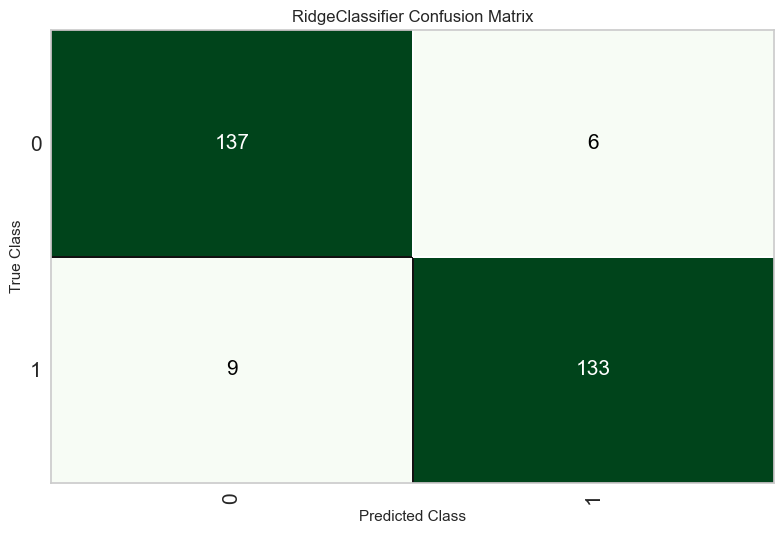

In [33]:
plot_model(tuned_model, plot='confusion_matrix')

## Predictions

In [ ]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Predict on Test

In [38]:
predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.9474,0.9473,0.9366,0.9568,0.9466,0.8947,0.8949


Unnamed: 0  \
547       17378   
343        9701   
760        6271   
824       14117   
784       13929   
..          ...   
524       10400   
379        6669   
612       11069   
867       10226   
165        8010   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Entrenamos el modelo sobre TODO el dataset de entrenamiento (incluyendo el holdout set). Sirve como paso final antes de hacer predicciones en datos nuevos reales o antes de guardar el modelo para producción.

In [40]:
final_model = finalize_model(tuned_model)

In [43]:
final_model.named_steps["actual_estimator"]

RidgeClassifier(alpha=0.61, class_weight=None, copy_X=True, fit_intercept=False,
                max_iter=None, positive=False, random_state=42, solver='auto',
                tol=0.0001)

In [42]:
save_model(final_model, './pkl/phishing_model_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['Unnamed: 0'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(ad...
                                     transformer=EmbedTextFeatures(kwargs=None,
                                                                   method='tf-idf'))),
            

## Predict on Unseen data

In [45]:
unseen_predictions = predict_model(final_model, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.9400,0.9423,0.8846,1.0000,0.9388,0.8804,0.8867


Unnamed: 0  \
0       14230   
1        8679   
2       13442   
3        7579   
4        8350   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [56]:
y_true = unseen_predictions['Email Type']
y_pred = unseen_predictions['prediction_label']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.94
Precision: 0.9466666666666665
Recall: 0.94
F1 Score: 0.9399279711884754
Confusion Matrix:
 [[24  0]
 [ 3 23]]
